#MOUNT DRIVE



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#IMPORT LIBRARIES

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# import torchvision.transforms as transforms
import torchvision
from torchvision import transforms, datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import copy
import random
import time
import argparse
from tqdm import tqdm

#SELECT CUDA / CPU

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)

Device: cuda


#SEED

In [ ]:
SEED = 100

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)
np.random.seed(SEED)

#DATA

1. Choose Normalization & Augmentation

In [55]:
class LoadDataset():
    
    def __init__(self,dataset,directory):
        self.dataset = dataset
        self.directory = directory
        self.train_transform = None
        self.test_transform = None
    
    def load_dataset(self,dataset= None):
        # Using mean and std deviation
        normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # Using Augmentation and Normalization on the dataset
        self.train_transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ColorJitter(brightness=2),
                                      transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      normalization,
                                                ])
     
        self.test_transform = transforms.Compose([
                                    transforms.Resize((32,32)),
                                    
                                     transforms.ToTensor(),
                                     normalization,
                                               ])
        trainset = []
        testset = []
        if self.dataset == 'CIFAR10':
            
            # Change path as per local directory/ drive
            trainset = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/CV-P3/CIFAR-data', train=True,
                                                          download=True, transform=self.train_transform)
            # Change path as per local directory/ drive
            testset = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/CV-P3/CIFAR-data', train=False,
                                                         download=True, transform=self.test_transform)
            
        elif self.dataset == 'FDDB':

                TRAIN_PATH = self.directory+'/Train/'
                TEST_PATH = self.directory+'/Test/'
                trainset = datasets.ImageFolder(root= TRAIN_PATH, transform=self.train_transform)
                print(trainset)
                testset = datasets.ImageFolder(root= TEST_PATH, transform=self.test_transform)
                print(testset)

        else:
            print('Enter valid dataset name')
            
        VAL_SPLIT = 0.9 # 90%- Train, 10%- Validation

        train_examples = int(len(trainset) * VAL_SPLIT)
        valid_examples = len(trainset) - train_examples
        train_data_, valid_data_ = data.random_split(trainset, 
                                          [train_examples,valid_examples])

        indices = list(range(0, int(len(trainset)*0.3), 1))
        data_subset = torch.utils.data.Subset(trainset, indices)
        VAL_SPLIT = 0.5 
        train_examples = int(len(data_subset) * VAL_SPLIT)
        valid_examples = len(data_subset) - train_examples
        
        train_data_subset, valid_data_subset = data.random_split(data_subset, 
                                                  [train_examples,valid_examples])
       
        
        print(f'Complete data')
        print(f'Images in training data: {len(train_data_)}')
        print(f'Images in validation data: {len(valid_data_)}')
        print(f'Images in test data: {len(testset)}')

        
        valid_data_ = copy.deepcopy(valid_data_) 
        valid_data_.dataset.transform = self.test_transform 
        
        
        BATCH_SIZE = 32 
        train_data_tiny = data.DataLoader(train_data_subset, 
                                        shuffle = True, 
                                        batch_size = BATCH_SIZE)
        
        valid_data_tiny = data.DataLoader(valid_data_subset, 
                                        batch_size = BATCH_SIZE)
        
        train_data = data.DataLoader(train_data_, 
                                        shuffle = True, 
                                        batch_size = BATCH_SIZE)
        
        valid_data = data.DataLoader(valid_data_, 
                                        batch_size = BATCH_SIZE)
        
        test_data = data.DataLoader(testset, 
                                        batch_size = BATCH_SIZE)
        
        print(f'Batch Size: {BATCH_SIZE}')
        print(f'Batches in overfitting training data: {len(train_data_tiny)}')
        print(f'Batches in overfitting valid data: {len(valid_data_tiny)}')
        print(f'Batches in training data: {len(train_data)}')
        print(f'Batches in validation data: {len(valid_data)}')
        print(f'Batches in test data: {len(test_data)}')

            
        return train_data_tiny, valid_data_tiny, train_data, test_data, valid_data
            
            

#CREATE MODEL - AlexNet CNN

In [56]:
class AlexNet(nn.Module):
    def __init__(self, no_output):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, no_output),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

#TRAIN MODEL

In [57]:

class Train:
 
  def __init__(self,model,optimizer,dataset):
        self.dataset = dataset
        self.mod = model
        self.opt = optimizer
        self.model = None
        self.optimizer = None
        self.criterion = None
        self.train_accuracy = []
        self.validation_accuracy = []
        self.train_loss = []
        self.validation_loss = []

  def calc_accuracy(self,y_prediction, y):
      top_prediction = y_prediction.argmax(1, keepdim = True)
      correct = top_prediction.eq(y.view_as(top_prediction)).sum()
      accuracy = correct.float() / y.shape[0]
      return accuracy

  def plot_metrics(self,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS):
    plt.plot(np.asarray(TRAIN_ACC),'r',label="Training")
    plt.plot(np.asarray(VAL_ACC),'b',label="Validation")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.plot(np.asarray(TRAIN_LOSS),'r',label="Training")
    plt.plot(np.asarray(VAL_LOSS),'b',label="Validation")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

  def evaluate(self,model, data_iterator, criterion, device):
      
      epoch_loss = 0
      epoch_acc = 0
      
      
      model.eval()
      
      with torch.no_grad():
          
          for (x, y) in data_iterator:

              x = x.to(device)
              y = y.to(device)

              y_prediction = model(x)

              loss = criterion(y_prediction, y)

              acc = self.calc_accuracy(y_prediction, y)

              epoch_loss += loss.item()
              epoch_acc += acc.item()
          
      return epoch_loss / len(data_iterator), epoch_acc / len(data_iterator)

  def back_prop(self, label, device):
    print("Device:",device)
    loss_per_epoch = 0
    accuracy_per_epoch = 0
    self.model.train()
    for (x, y) in label:
        
        x = x.to(device)
        y = y.to(device)
        self.optimizer.zero_grad()
        y_pred = self.model(x)
        loss_var = self.criterion(y_pred, y)
        loss_var.backward()
        accuracy_var = self.calc_accuracy(y_pred, y)
        self.optimizer.step()
        loss_per_epoch += loss_var.item()
        accuracy_per_epoch += accuracy_var.item()

    return loss_per_epoch / len(label), accuracy_per_epoch / len(label)


  def train_model(self,train_data_iterator,valid_data_iterator,device,optimizer,num_epochs,learning_rate,wd):
        
        if(self.dataset == 'CIFAR10'):
         num_output = 10
        elif (self.dataset == 'FDDB'):
         num_output = 2
        
        if(self.mod == 'AlexNet'):
          model = AlexNet(num_output)
        
        if self.opt == 'SGD':
          optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd, momentum = 0.9)
        elif self.opt == 'Adam':
          optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)

        criterion = nn.CrossEntropyLoss()

        model = model.to(device)
        criterion = criterion.to(device)
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        ideal_loss = float('inf')
        
        for epoch in tqdm(range(num_epochs)):
            
            start_time = time.time()
            
            training_loss, training_accuracy = self.back_prop(train_data_iterator, device)
            validation_loss, validation_accuracy = self.evaluate(model,valid_data_iterator, criterion, device)
            
            if validation_loss < ideal_loss:
                ideal_loss = validation_loss
                torch.save(model.state_dict(), 'alexnet_model.pt')
            
            end_time = time.time()

            time_elapsed = end_time - start_time
            epoch_mins = int(time_elapsed / 60)
            epoch_secs = int(time_elapsed - (epoch_mins * 60))

            self.train_accuracy.append(training_accuracy)
            self.train_loss.append(training_loss)
            self.validation_accuracy.append(validation_accuracy)
            self.validation_loss.append(validation_loss)
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\t Training Loss: {training_loss:.3f} | Validation Loss: {validation_loss:.3f} | Learning rate: {learning_rate}| Reg:{wd}')
            print(f'\t Training Accuracy: {training_accuracy*100:.2f}% |  Validation Accuracy: {validation_accuracy*100:.2f}%')
        if num_epochs != 1:
            self.plot_metrics(self.train_accuracy,self.validation_accuracy,self.train_loss,self.validation_loss)    



Files already downloaded and verified
Files already downloaded and verified
Complete data
Images in training data: 45000
Images in validation data: 5000
Images in test data: 10000
Batch Size: 32
Batches in overfitting training data: 235
Batches in overfitting valid data: 235
Batches in training data: 1407
Batches in validation data: 157
Batches in test data: 313


  0%|          | 0/1 [00:00<?, ?it/s]

Device: cuda


100%|██████████| 1/1 [00:36<00:00, 36.04s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.301 | Learning rate: 0.001| Reg:0
	 Training Accuracy: 10.42% |  Validation Accuracy: 13.28%


first Loss: 2.3011567988715615


  0%|          | 0/30 [00:00<?, ?it/s]

Device: cuda


  3%|▎         | 1/30 [00:09<04:43,  9.78s/it]

Epoch: 01 | Epoch Time: 0m 9s
	 Training Loss: 2.303 | Validation Loss: 2.302 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 9.47% |  Validation Accuracy: 10.12%
Device: cuda


  7%|▋         | 2/30 [00:19<04:35,  9.84s/it]

Epoch: 02 | Epoch Time: 0m 9s
	 Training Loss: 2.302 | Validation Loss: 2.300 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 10.75% |  Validation Accuracy: 12.15%
Device: cuda


 10%|█         | 3/30 [00:29<04:25,  9.85s/it]

Epoch: 03 | Epoch Time: 0m 9s
	 Training Loss: 2.298 | Validation Loss: 2.290 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 12.25% |  Validation Accuracy: 15.17%
Device: cuda


 13%|█▎        | 4/30 [00:39<04:16,  9.85s/it]

Epoch: 04 | Epoch Time: 0m 9s
	 Training Loss: 2.248 | Validation Loss: 2.172 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 15.00% |  Validation Accuracy: 17.42%
Device: cuda


 17%|█▋        | 5/30 [00:49<04:06,  9.85s/it]

Epoch: 05 | Epoch Time: 0m 9s
	 Training Loss: 2.157 | Validation Loss: 2.077 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 18.41% |  Validation Accuracy: 21.37%
Device: cuda


 20%|██        | 6/30 [00:58<03:54,  9.77s/it]

Epoch: 06 | Epoch Time: 0m 9s
	 Training Loss: 2.061 | Validation Loss: 2.097 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 21.06% |  Validation Accuracy: 20.16%
Device: cuda


 23%|██▎       | 7/30 [01:08<03:44,  9.75s/it]

Epoch: 07 | Epoch Time: 0m 9s
	 Training Loss: 2.013 | Validation Loss: 1.985 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 22.13% |  Validation Accuracy: 23.21%
Device: cuda


 27%|██▋       | 8/30 [01:18<03:34,  9.76s/it]

Epoch: 08 | Epoch Time: 0m 9s
	 Training Loss: 1.981 | Validation Loss: 1.904 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 22.89% |  Validation Accuracy: 26.25%
Device: cuda


 30%|███       | 9/30 [01:27<03:24,  9.72s/it]

Epoch: 09 | Epoch Time: 0m 9s
	 Training Loss: 1.914 | Validation Loss: 1.939 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 24.97% |  Validation Accuracy: 26.23%
Device: cuda


 33%|███▎      | 10/30 [01:37<03:15,  9.76s/it]

Epoch: 10 | Epoch Time: 0m 9s
	 Training Loss: 1.901 | Validation Loss: 1.842 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 25.23% |  Validation Accuracy: 28.52%
Device: cuda


 37%|███▋      | 11/30 [01:47<03:05,  9.77s/it]

Epoch: 11 | Epoch Time: 0m 9s
	 Training Loss: 1.862 | Validation Loss: 1.809 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 27.20% |  Validation Accuracy: 29.06%
Device: cuda


 40%|████      | 12/30 [01:57<02:56,  9.79s/it]

Epoch: 12 | Epoch Time: 0m 9s
	 Training Loss: 1.822 | Validation Loss: 1.805 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 29.09% |  Validation Accuracy: 31.00%
Device: cuda


 43%|████▎     | 13/30 [02:07<02:45,  9.74s/it]

Epoch: 13 | Epoch Time: 0m 9s
	 Training Loss: 1.805 | Validation Loss: 1.940 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 30.02% |  Validation Accuracy: 29.85%
Device: cuda


 47%|████▋     | 14/30 [02:16<02:35,  9.72s/it]

Epoch: 14 | Epoch Time: 0m 9s
	 Training Loss: 1.782 | Validation Loss: 1.721 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 30.92% |  Validation Accuracy: 33.59%
Device: cuda


 50%|█████     | 15/30 [02:26<02:26,  9.74s/it]

Epoch: 15 | Epoch Time: 0m 9s
	 Training Loss: 1.748 | Validation Loss: 1.692 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 31.85% |  Validation Accuracy: 34.77%
Device: cuda


 53%|█████▎    | 16/30 [02:36<02:15,  9.71s/it]

Epoch: 16 | Epoch Time: 0m 9s
	 Training Loss: 1.727 | Validation Loss: 1.649 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 34.27% |  Validation Accuracy: 37.44%
Device: cuda


 57%|█████▋    | 17/30 [02:45<02:05,  9.64s/it]

Epoch: 17 | Epoch Time: 0m 9s
	 Training Loss: 1.701 | Validation Loss: 1.823 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 34.95% |  Validation Accuracy: 30.62%
Device: cuda


 60%|██████    | 18/30 [02:55<01:55,  9.65s/it]

Epoch: 18 | Epoch Time: 0m 9s
	 Training Loss: 1.669 | Validation Loss: 1.622 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 36.24% |  Validation Accuracy: 39.75%
Device: cuda


 63%|██████▎   | 19/30 [03:04<01:45,  9.59s/it]

Epoch: 19 | Epoch Time: 0m 9s
	 Training Loss: 1.660 | Validation Loss: 1.627 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 37.56% |  Validation Accuracy: 39.53%
Device: cuda


 67%|██████▋   | 20/30 [03:14<01:35,  9.57s/it]

Epoch: 20 | Epoch Time: 0m 9s
	 Training Loss: 1.613 | Validation Loss: 1.591 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 38.98% |  Validation Accuracy: 40.57%
Device: cuda


 70%|███████   | 21/30 [03:23<01:25,  9.52s/it]

Epoch: 21 | Epoch Time: 0m 9s
	 Training Loss: 1.587 | Validation Loss: 1.631 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 40.53% |  Validation Accuracy: 38.25%
Device: cuda


 73%|███████▎  | 22/30 [03:33<01:16,  9.50s/it]

Epoch: 22 | Epoch Time: 0m 9s
	 Training Loss: 1.586 | Validation Loss: 1.578 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 41.01% |  Validation Accuracy: 41.48%
Device: cuda


 77%|███████▋  | 23/30 [03:42<01:06,  9.45s/it]

Epoch: 23 | Epoch Time: 0m 9s
	 Training Loss: 1.512 | Validation Loss: 1.588 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 43.00% |  Validation Accuracy: 40.84%
Device: cuda


 80%|████████  | 24/30 [03:52<00:56,  9.48s/it]

Epoch: 24 | Epoch Time: 0m 9s
	 Training Loss: 1.504 | Validation Loss: 1.521 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 44.07% |  Validation Accuracy: 43.35%
Device: cuda


 83%|████████▎ | 25/30 [04:01<00:47,  9.49s/it]

Epoch: 25 | Epoch Time: 0m 9s
	 Training Loss: 1.474 | Validation Loss: 1.511 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 45.22% |  Validation Accuracy: 43.94%
Device: cuda


 87%|████████▋ | 26/30 [04:10<00:37,  9.43s/it]

Epoch: 26 | Epoch Time: 0m 9s
	 Training Loss: 1.464 | Validation Loss: 1.528 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 45.65% |  Validation Accuracy: 45.16%
Device: cuda


 90%|█████████ | 27/30 [04:20<00:28,  9.45s/it]

Epoch: 27 | Epoch Time: 0m 9s
	 Training Loss: 1.443 | Validation Loss: 1.461 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 47.01% |  Validation Accuracy: 46.53%
Device: cuda


 93%|█████████▎| 28/30 [04:29<00:18,  9.48s/it]

Epoch: 28 | Epoch Time: 0m 9s
	 Training Loss: 1.408 | Validation Loss: 1.447 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 48.24% |  Validation Accuracy: 47.52%
Device: cuda


 97%|█████████▋| 29/30 [04:39<00:09,  9.49s/it]

Epoch: 29 | Epoch Time: 0m 9s
	 Training Loss: 1.391 | Validation Loss: 1.445 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 48.64% |  Validation Accuracy: 47.63%
Device: cuda


100%|██████████| 30/30 [04:49<00:00,  9.64s/it]

Epoch: 30 | Epoch Time: 0m 9s
	 Training Loss: 1.386 | Validation Loss: 1.440 | Learning rate: 0.005| Reg:0
	 Training Accuracy: 47.98% |  Validation Accuracy: 47.13%


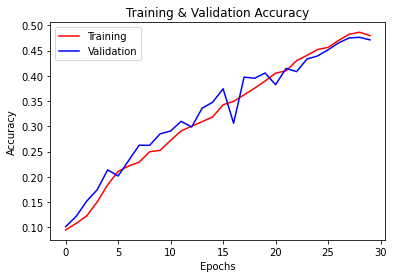

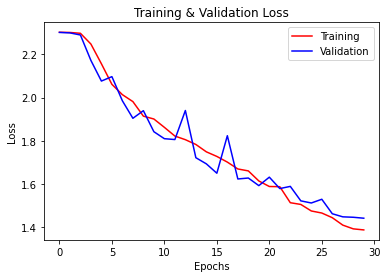

In [58]:

# Change path as per directory
dataset = LoadDataset("CIFAR10", "/content/drive/My Drive/CV-P3/CIFAR-data")
    
traintiny, validtiny, trainset, testset, validset = dataset.load_dataset()
    
#Printing first loss
tr = Train("AlexNet","SGD","CIFAR10")
tr.train_model(trainset, validset, "cuda", "SGD", 1, 10**-3, 0)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to("cuda")
test_loss, _ = tr.evaluate(tr.model, testset, criterion, "cuda")
print(f'first Loss: {test_loss}')
    
#Overfitting Model
tr = Train("AlexNet","SGD","CIFAR10")
tr.train_model(traintiny, validtiny, "cuda", "SGD", 30,5*10**-3, 0)

    

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

  0%|          | 0/10 [00:00<?, ?it/s]

Device: cuda


 10%|█         | 1/10 [00:36<05:26, 36.32s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.02% |  Validation Accuracy: 9.14%
Device: cuda


 20%|██        | 2/10 [01:13<04:53, 36.73s/it]

Epoch: 02 | Epoch Time: 0m 37s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.09% |  Validation Accuracy: 9.14%
Device: cuda


 30%|███       | 3/10 [01:50<04:17, 36.84s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.11% |  Validation Accuracy: 9.14%
Device: cuda


 40%|████      | 4/10 [02:26<03:38, 36.45s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.06% |  Validation Accuracy: 9.14%
Device: cuda


 50%|█████     | 5/10 [03:02<03:01, 36.28s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.11% |  Validation Accuracy: 9.14%
Device: cuda


 60%|██████    | 6/10 [03:37<02:24, 36.13s/it]

Epoch: 06 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.06% |  Validation Accuracy: 9.14%
Device: cuda


 70%|███████   | 7/10 [04:13<01:48, 36.08s/it]

Epoch: 07 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.14% |  Validation Accuracy: 9.14%
Device: cuda


 80%|████████  | 8/10 [04:49<01:12, 36.05s/it]

Epoch: 08 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.03% |  Validation Accuracy: 9.14%
Device: cuda


 90%|█████████ | 9/10 [05:25<00:36, 36.03s/it]

Epoch: 09 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.10% |  Validation Accuracy: 9.14%
Device: cuda


100%|██████████| 10/10 [06:01<00:00, 36.18s/it]

Epoch: 10 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1e-06
	 Training Accuracy: 10.13% |  Validation Accuracy: 9.14%


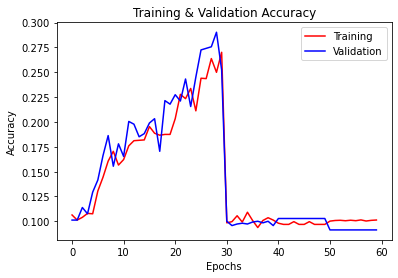

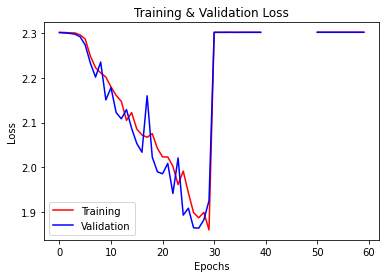

In [36]:
#Train loss and validation loss barely change
tr.train_model(trainset, validset, "cuda", "SGD", 10,10**-6, 10**-6)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

  0%|          | 0/10 [00:00<?, ?it/s]

Device: cuda


 10%|█         | 1/10 [00:36<05:26, 36.27s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 10.02% |  Validation Accuracy: 10.03%
Device: cuda


 20%|██        | 2/10 [01:12<04:49, 36.16s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 30%|███       | 3/10 [01:51<04:21, 37.33s/it]

Epoch: 03 | Epoch Time: 0m 38s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda


 40%|████      | 4/10 [02:31<03:51, 38.58s/it]

Epoch: 04 | Epoch Time: 0m 40s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%
Device: cuda


 50%|█████     | 5/10 [03:13<03:18, 39.63s/it]

Epoch: 05 | Epoch Time: 0m 41s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%
Device: cuda


 60%|██████    | 6/10 [03:48<02:33, 38.29s/it]

Epoch: 06 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda


 70%|███████   | 7/10 [04:24<01:52, 37.45s/it]

Epoch: 07 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 80%|████████  | 8/10 [05:01<01:14, 37.30s/it]

Epoch: 08 | Epoch Time: 0m 36s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 90%|█████████ | 9/10 [05:39<00:37, 37.49s/it]

Epoch: 09 | Epoch Time: 0m 37s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda


100%|██████████| 10/10 [06:15<00:00, 37.53s/it]

Epoch: 10 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000000
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%


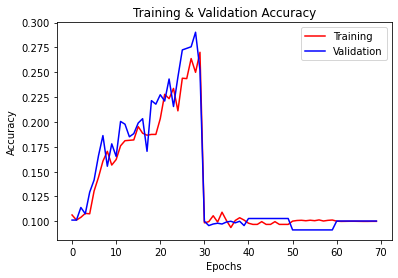

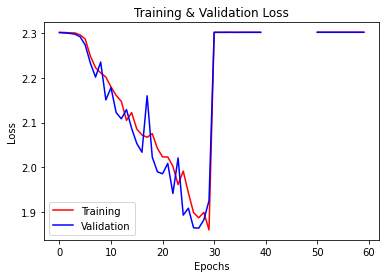

In [37]:
#High learning rate makes the loss to explode 
tr.train_model(trainset, validset, "cuda", "SGD", 10,10**6, 10**-6)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

  0%|          | 0/10 [00:00<?, ?it/s]

Device: cuda


 10%|█         | 1/10 [00:36<05:26, 36.24s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.001
	 Training Accuracy: 10.44% |  Validation Accuracy: 9.02%
Device: cuda


 20%|██        | 2/10 [01:12<04:50, 36.28s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.301 | Validation Loss: 2.295 | Learning rate: 0.001
	 Training Accuracy: 11.18% |  Validation Accuracy: 11.74%
Device: cuda


 30%|███       | 3/10 [01:48<04:13, 36.16s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 2.232 | Validation Loss: 2.123 | Learning rate: 0.001
	 Training Accuracy: 15.07% |  Validation Accuracy: 17.18%
Device: cuda


 40%|████      | 4/10 [02:26<03:41, 36.95s/it]

Epoch: 04 | Epoch Time: 0m 38s
	 Training Loss: 2.058 | Validation Loss: 1.918 | Learning rate: 0.001
	 Training Accuracy: 20.30% |  Validation Accuracy: 23.37%
Device: cuda


 50%|█████     | 5/10 [03:06<03:09, 37.85s/it]

Epoch: 05 | Epoch Time: 0m 39s
	 Training Loss: 1.936 | Validation Loss: 1.826 | Learning rate: 0.001
	 Training Accuracy: 23.91% |  Validation Accuracy: 27.19%
Device: cuda


 60%|██████    | 6/10 [03:43<02:30, 37.61s/it]

Epoch: 06 | Epoch Time: 0m 37s
	 Training Loss: 1.864 | Validation Loss: 1.845 | Learning rate: 0.001
	 Training Accuracy: 26.89% |  Validation Accuracy: 27.07%
Device: cuda


 70%|███████   | 7/10 [04:20<01:52, 37.38s/it]

Epoch: 07 | Epoch Time: 0m 36s
	 Training Loss: 1.810 | Validation Loss: 1.699 | Learning rate: 0.001
	 Training Accuracy: 28.54% |  Validation Accuracy: 33.06%
Device: cuda


 80%|████████  | 8/10 [04:57<01:14, 37.23s/it]

Epoch: 08 | Epoch Time: 0m 36s
	 Training Loss: 1.768 | Validation Loss: 1.691 | Learning rate: 0.001
	 Training Accuracy: 31.16% |  Validation Accuracy: 34.65%
Device: cuda


 90%|█████████ | 9/10 [05:33<00:36, 36.90s/it]

Epoch: 09 | Epoch Time: 0m 36s
	 Training Loss: 1.717 | Validation Loss: 1.613 | Learning rate: 0.001
	 Training Accuracy: 33.59% |  Validation Accuracy: 38.83%
Device: cuda


100%|██████████| 10/10 [06:09<00:00, 36.95s/it]

Epoch: 10 | Epoch Time: 0m 36s
	 Training Loss: 1.663 | Validation Loss: 1.528 | Learning rate: 0.001
	 Training Accuracy: 36.45% |  Validation Accuracy: 41.08%


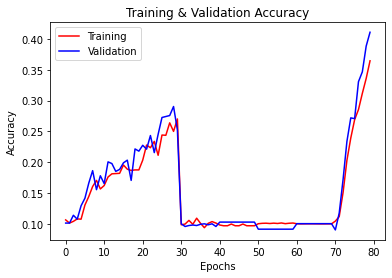

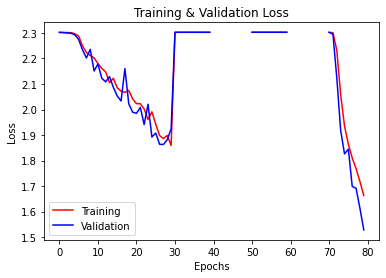

In [38]:
tr.train_model(trainset, validset, "cuda", "SGD", 10,10**-3, 10**-6)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

  0%|          | 0/10 [00:00<?, ?it/s]

Device: cuda


 10%|█         | 1/10 [00:36<05:25, 36.13s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.301 | Learning rate: 0.001
	 Training Accuracy: 10.79% |  Validation Accuracy: 14.99%
Device: cuda


 20%|██        | 2/10 [01:12<04:48, 36.11s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.296 | Validation Loss: 2.263 | Learning rate: 0.001
	 Training Accuracy: 12.24% |  Validation Accuracy: 16.70%
Device: cuda


 30%|███       | 3/10 [01:48<04:12, 36.13s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 2.183 | Validation Loss: 2.033 | Learning rate: 0.001
	 Training Accuracy: 17.71% |  Validation Accuracy: 20.66%
Device: cuda


 40%|████      | 4/10 [02:24<03:36, 36.10s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 2.019 | Validation Loss: 1.905 | Learning rate: 0.001
	 Training Accuracy: 22.00% |  Validation Accuracy: 24.48%
Device: cuda


 50%|█████     | 5/10 [03:00<03:00, 36.15s/it]

Epoch: 05 | Epoch Time: 0m 36s
	 Training Loss: 1.924 | Validation Loss: 1.810 | Learning rate: 0.001
	 Training Accuracy: 24.70% |  Validation Accuracy: 27.07%
Device: cuda


 60%|██████    | 6/10 [03:36<02:24, 36.09s/it]

Epoch: 06 | Epoch Time: 0m 35s
	 Training Loss: 1.864 | Validation Loss: 1.767 | Learning rate: 0.001
	 Training Accuracy: 26.73% |  Validation Accuracy: 29.76%
Device: cuda


 70%|███████   | 7/10 [04:12<01:48, 36.09s/it]

Epoch: 07 | Epoch Time: 0m 36s
	 Training Loss: 1.812 | Validation Loss: 1.716 | Learning rate: 0.001
	 Training Accuracy: 28.58% |  Validation Accuracy: 31.57%
Device: cuda


 80%|████████  | 8/10 [04:48<01:12, 36.09s/it]

Epoch: 08 | Epoch Time: 0m 36s
	 Training Loss: 1.771 | Validation Loss: 1.667 | Learning rate: 0.001
	 Training Accuracy: 30.36% |  Validation Accuracy: 34.18%
Device: cuda


 90%|█████████ | 9/10 [05:24<00:36, 36.04s/it]

Epoch: 09 | Epoch Time: 0m 35s
	 Training Loss: 1.728 | Validation Loss: 1.589 | Learning rate: 0.001
	 Training Accuracy: 32.49% |  Validation Accuracy: 38.89%
Device: cuda


100%|██████████| 10/10 [06:01<00:00, 36.11s/it]

Epoch: 10 | Epoch Time: 0m 36s
	 Training Loss: 1.677 | Validation Loss: 1.531 | Learning rate: 0.001
	 Training Accuracy: 35.06% |  Validation Accuracy: 41.12%


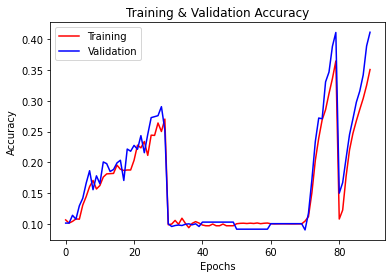

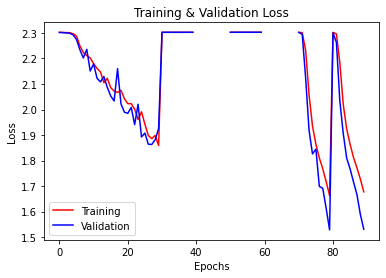

In [39]:
tr.train_model(trainset, validset, "cuda", "SGD", 10,10**-3, 10**-3)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

  0%|          | 0/10 [00:00<?, ?it/s]

Device: cuda


 10%|█         | 1/10 [00:36<05:25, 36.15s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 9.81% |  Validation Accuracy: 10.17%
Device: cuda


 20%|██        | 2/10 [01:12<04:48, 36.07s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 10.02% |  Validation Accuracy: 9.26%
Device: cuda


 30%|███       | 3/10 [01:48<04:12, 36.00s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 10.11% |  Validation Accuracy: 11.23%
Device: cuda


 40%|████      | 4/10 [02:23<03:34, 35.83s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 10.11% |  Validation Accuracy: 9.14%
Device: cuda


 50%|█████     | 5/10 [02:59<02:58, 35.75s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 10.01% |  Validation Accuracy: 9.14%
Device: cuda


 60%|██████    | 6/10 [03:34<02:22, 35.75s/it]

Epoch: 06 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 9.94% |  Validation Accuracy: 10.03%
Device: cuda


 70%|███████   | 7/10 [04:10<01:47, 35.69s/it]

Epoch: 07 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 10.20% |  Validation Accuracy: 10.03%
Device: cuda


 80%|████████  | 8/10 [04:46<01:11, 35.63s/it]

Epoch: 08 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 9.83% |  Validation Accuracy: 11.23%
Device: cuda


 90%|█████████ | 9/10 [05:21<00:35, 35.50s/it]

Epoch: 09 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 10.07% |  Validation Accuracy: 10.71%
Device: cuda


100%|██████████| 10/10 [05:56<00:00, 35.67s/it]

Epoch: 10 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.001
	 Training Accuracy: 10.03% |  Validation Accuracy: 10.11%


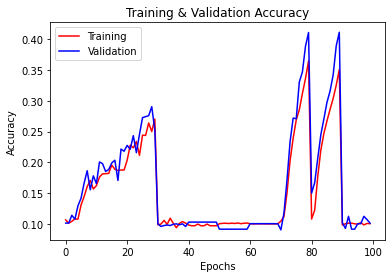

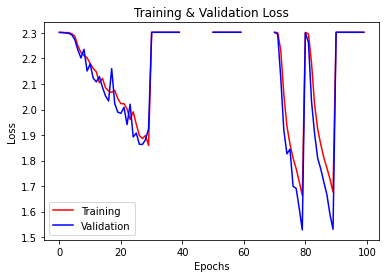

In [40]:
tr.train_model(trainset, validset, "cuda", "SGD", 10,10**-3, 10**3)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

  0%|          | 0/10 [00:00<?, ?it/s]

Device: cuda


 10%|█         | 1/10 [00:35<05:17, 35.27s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 20%|██        | 2/10 [01:10<04:43, 35.48s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda


 30%|███       | 3/10 [01:46<04:07, 35.35s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 40%|████      | 4/10 [02:21<03:31, 35.25s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 50%|█████     | 5/10 [02:56<02:55, 35.19s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 60%|██████    | 6/10 [03:32<02:21, 35.39s/it]

Epoch: 06 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda


 70%|███████   | 7/10 [04:07<01:46, 35.38s/it]

Epoch: 07 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda


 80%|████████  | 8/10 [04:42<01:10, 35.35s/it]

Epoch: 08 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda


 90%|█████████ | 9/10 [05:17<00:35, 35.33s/it]

Epoch: 09 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%
Device: cuda


100%|██████████| 10/10 [05:53<00:00, 35.33s/it]

Epoch: 10 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.001
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%


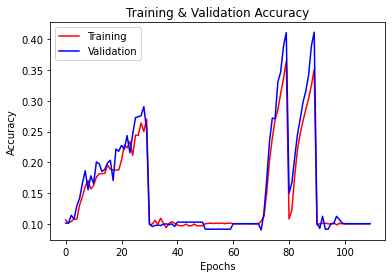

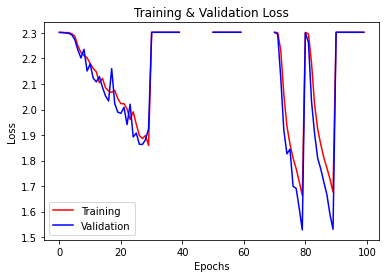

In [41]:
tr.train_model(trainset, validset, "cuda", "SGD", 10,10**-3, 10**4)

### **Coarse Train**

  0%|          | 0/20 [00:00<?, ?it/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:24, 36.12s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 0.0002862151057412364
	 Training Accuracy: 10.07% |  Validation Accuracy: 12.54%
Device: cuda



 40%|████      | 2/5 [01:12<01:48, 36.20s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.0002862151057412364
	 Training Accuracy: 10.92% |  Validation Accuracy: 15.03%
Device: cuda



 60%|██████    | 3/5 [01:48<01:12, 36.32s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.0002862151057412364
	 Training Accuracy: 10.71% |  Validation Accuracy: 14.53%
Device: cuda



 80%|████████  | 4/5 [02:25<00:36, 36.33s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.301 | Learning rate: 0.0002862151057412364
	 Training Accuracy: 11.43% |  Validation Accuracy: 13.75%
Device: cuda



100%|██████████| 5/5 [03:01<00:00, 36.30s/it]

Epoch: 05 | Epoch Time: 0m 36s
	 Training Loss: 2.301 | Validation Loss: 2.300 | Learning rate: 0.0002862151057412364
	 Training Accuracy: 11.01% |  Validation Accuracy: 11.39%


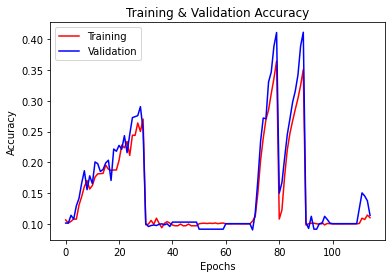

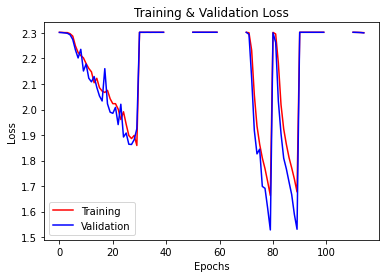

  5%|▌         | 1/20 [03:01<57:36, 181.95s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:24, 36.03s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 510.314674028669
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.95s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 510.314674028669
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.96s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 510.314674028669
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.95s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 510.314674028669
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.93s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 510.314674028669
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%


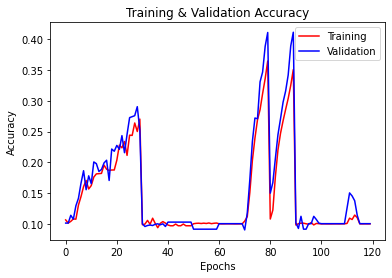

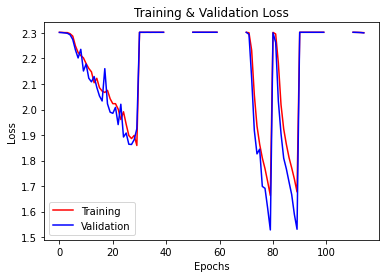

 10%|█         | 2/20 [06:02<54:15, 180.87s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.85s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 208.73233448444347
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.71s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 208.73233448444347
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.76s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 208.73233448444347
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.72s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 208.73233448444347
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:58<00:00, 35.77s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 208.73233448444347
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%


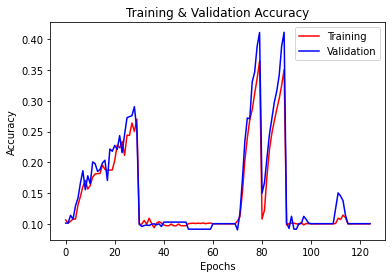

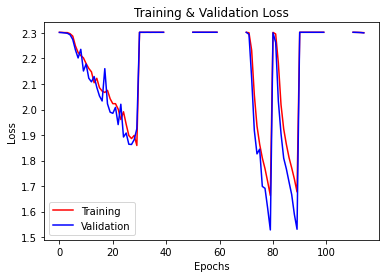

 15%|█▌        | 3/20 [09:01<51:02, 180.16s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:24, 36.05s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000.4711538628923
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:12<01:48, 36.07s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000.4711538628923
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:48<01:12, 36.05s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000.4711538628923
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.93s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000.4711538628923
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.95s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1000.4711538628923
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%


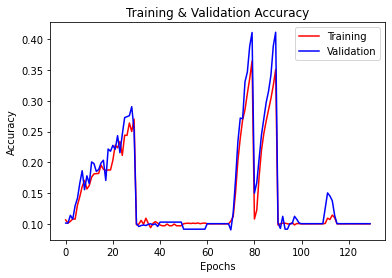

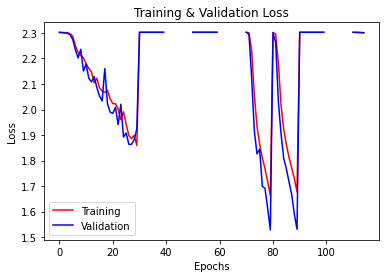

 20%|██        | 4/20 [12:01<48:03, 180.20s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:24, 36.23s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 6.331944386333944e-05
	 Training Accuracy: 10.04% |  Validation Accuracy: 9.04%
Device: cuda



 40%|████      | 2/5 [01:12<01:48, 36.31s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 6.331944386333944e-05
	 Training Accuracy: 10.03% |  Validation Accuracy: 9.69%
Device: cuda



 60%|██████    | 3/5 [01:48<01:12, 36.28s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.303 | Learning rate: 6.331944386333944e-05
	 Training Accuracy: 10.19% |  Validation Accuracy: 9.79%
Device: cuda



 80%|████████  | 4/5 [02:25<00:36, 36.33s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.303 | Learning rate: 6.331944386333944e-05
	 Training Accuracy: 10.61% |  Validation Accuracy: 12.42%
Device: cuda



100%|██████████| 5/5 [03:01<00:00, 36.30s/it]

Epoch: 05 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 6.331944386333944e-05
	 Training Accuracy: 10.63% |  Validation Accuracy: 11.90%


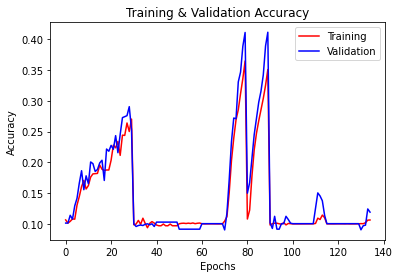

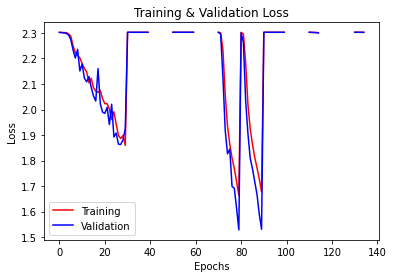

 25%|██▌       | 5/20 [15:03<45:12, 180.84s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:24, 36.12s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.303 | Validation Loss: 2.302 | Learning rate: 3.0121400777449763e-05
	 Training Accuracy: 9.63% |  Validation Accuracy: 11.25%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.96s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.302 | Learning rate: 3.0121400777449763e-05
	 Training Accuracy: 9.83% |  Validation Accuracy: 11.21%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.93s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.302 | Learning rate: 3.0121400777449763e-05
	 Training Accuracy: 10.04% |  Validation Accuracy: 11.09%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.94s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.302 | Learning rate: 3.0121400777449763e-05
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.55%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.94s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.302 | Learning rate: 3.0121400777449763e-05
	 Training Accuracy: 10.18% |  Validation Accuracy: 10.47%


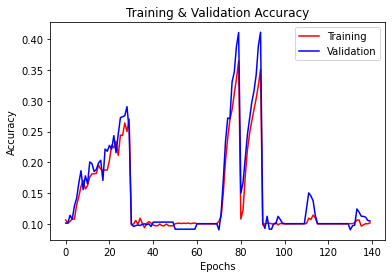

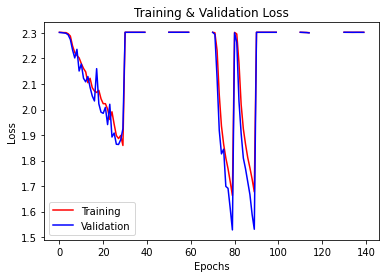

 30%|███       | 6/20 [18:03<42:08, 180.64s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.77s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 29565.148180857355
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.73s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 29565.148180857355
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.75s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 29565.148180857355
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.76s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 29565.148180857355
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:58<00:00, 35.77s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 29565.148180857355
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%


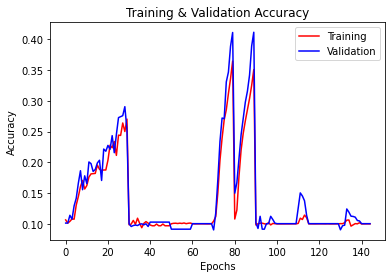

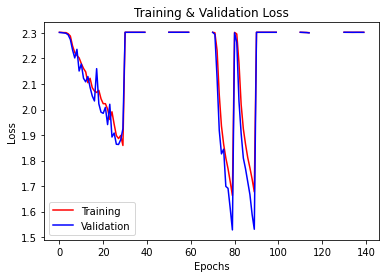

 35%|███▌      | 7/20 [21:03<39:02, 180.23s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:24, 36.16s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.114 | Validation Loss: 1.797 | Learning rate: 0.01241821833876381
	 Training Accuracy: 18.83% |  Validation Accuracy: 29.08%
Device: cuda



 40%|████      | 2/5 [01:12<01:48, 36.19s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 1.805 | Validation Loss: 1.627 | Learning rate: 0.01241821833876381
	 Training Accuracy: 30.57% |  Validation Accuracy: 39.85%
Device: cuda



 60%|██████    | 3/5 [01:48<01:12, 36.24s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 1.639 | Validation Loss: 1.406 | Learning rate: 0.01241821833876381
	 Training Accuracy: 39.00% |  Validation Accuracy: 47.07%
Device: cuda



 80%|████████  | 4/5 [02:25<00:36, 36.29s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 1.519 | Validation Loss: 1.295 | Learning rate: 0.01241821833876381
	 Training Accuracy: 44.43% |  Validation Accuracy: 51.95%
Device: cuda



100%|██████████| 5/5 [03:01<00:00, 36.28s/it]

Epoch: 05 | Epoch Time: 0m 36s
	 Training Loss: 1.425 | Validation Loss: 1.219 | Learning rate: 0.01241821833876381
	 Training Accuracy: 48.53% |  Validation Accuracy: 55.02%


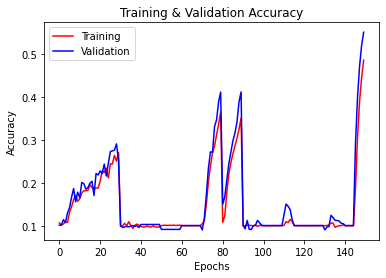

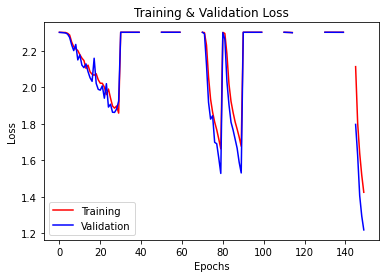

 40%|████      | 8/20 [24:05<36:09, 180.76s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:25, 36.26s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.301 | Learning rate: 0.0010931890874185904
	 Training Accuracy: 10.53% |  Validation Accuracy: 15.45%
Device: cuda



 40%|████      | 2/5 [01:12<01:48, 36.23s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.299 | Validation Loss: 2.288 | Learning rate: 0.0010931890874185904
	 Training Accuracy: 11.73% |  Validation Accuracy: 18.71%
Device: cuda



 60%|██████    | 3/5 [01:48<01:12, 36.21s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 2.199 | Validation Loss: 2.055 | Learning rate: 0.0010931890874185904
	 Training Accuracy: 17.29% |  Validation Accuracy: 19.69%
Device: cuda



 80%|████████  | 4/5 [02:24<00:36, 36.07s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.006 | Validation Loss: 1.885 | Learning rate: 0.0010931890874185904
	 Training Accuracy: 22.41% |  Validation Accuracy: 25.68%
Device: cuda



100%|██████████| 5/5 [03:00<00:00, 36.00s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.910 | Validation Loss: 1.781 | Learning rate: 0.0010931890874185904
	 Training Accuracy: 25.32% |  Validation Accuracy: 27.39%


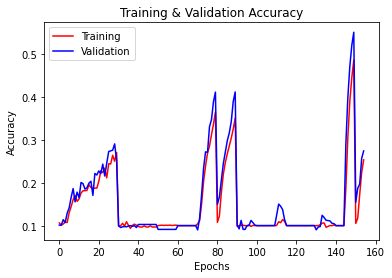

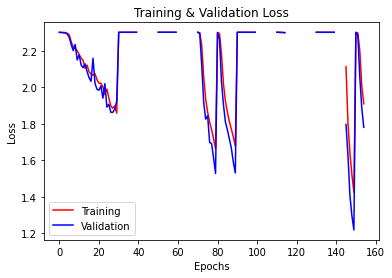

 45%|████▌     | 9/20 [27:05<33:07, 180.68s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.80s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.0007690403761860845
	 Training Accuracy: 10.28% |  Validation Accuracy: 14.29%
Device: cuda



 40%|████      | 2/5 [01:11<01:46, 35.56s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.300 | Learning rate: 0.0007690403761860845
	 Training Accuracy: 10.54% |  Validation Accuracy: 13.54%
Device: cuda



 60%|██████    | 3/5 [01:46<01:11, 35.55s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.297 | Validation Loss: 2.286 | Learning rate: 0.0007690403761860845
	 Training Accuracy: 11.35% |  Validation Accuracy: 11.86%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.56s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.225 | Validation Loss: 2.124 | Learning rate: 0.0007690403761860845
	 Training Accuracy: 15.31% |  Validation Accuracy: 20.06%
Device: cuda



100%|██████████| 5/5 [02:57<00:00, 35.60s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.055 | Validation Loss: 1.916 | Learning rate: 0.0007690403761860845
	 Training Accuracy: 20.72% |  Validation Accuracy: 21.88%


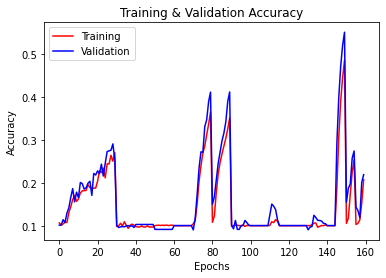

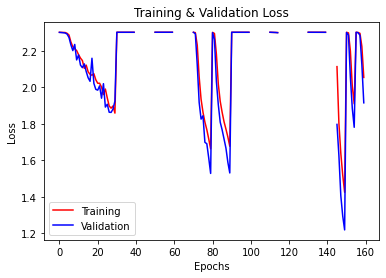

 50%|█████     | 10/20 [30:04<30:00, 180.00s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:22, 35.71s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 18.33227620358218
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:10<01:45, 35.28s/it]

Epoch: 02 | Epoch Time: 0m 34s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 18.33227620358218
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:45<01:10, 35.17s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 18.33227620358218
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:20<00:35, 35.12s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 18.33227620358218
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:55<00:00, 35.17s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 18.33227620358218
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%


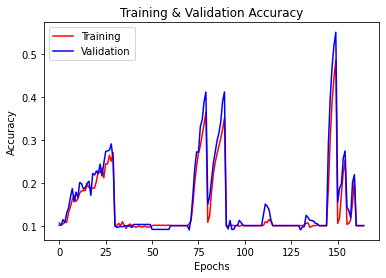

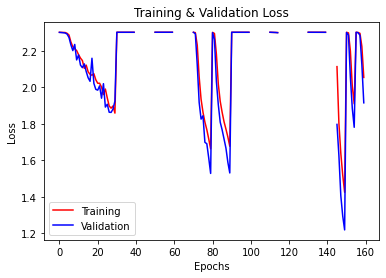

 55%|█████▌    | 11/20 [33:00<26:49, 178.88s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:22, 35.58s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.300 | Learning rate: 0.0012833346514923682
	 Training Accuracy: 10.55% |  Validation Accuracy: 17.64%
Device: cuda



 40%|████      | 2/5 [01:11<01:46, 35.60s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.274 | Validation Loss: 2.162 | Learning rate: 0.0012833346514923682
	 Training Accuracy: 12.70% |  Validation Accuracy: 17.22%
Device: cuda



 60%|██████    | 3/5 [01:46<01:11, 35.60s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.102 | Validation Loss: 1.902 | Learning rate: 0.0012833346514923682
	 Training Accuracy: 19.10% |  Validation Accuracy: 23.33%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.52s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 1.929 | Validation Loss: 1.871 | Learning rate: 0.0012833346514923682
	 Training Accuracy: 24.34% |  Validation Accuracy: 26.19%
Device: cuda



100%|██████████| 5/5 [02:58<00:00, 35.60s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.851 | Validation Loss: 1.738 | Learning rate: 0.0012833346514923682
	 Training Accuracy: 27.30% |  Validation Accuracy: 31.13%


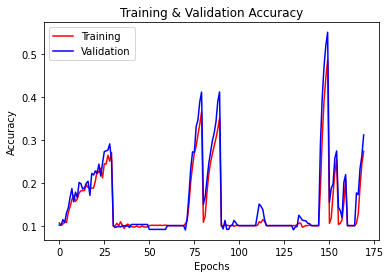

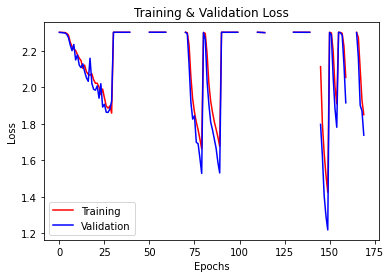

 60%|██████    | 12/20 [35:58<23:50, 178.77s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:21, 35.36s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 3.5809368148424814
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:10<01:46, 35.45s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 3.5809368148424814
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:46<01:10, 35.45s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 3.5809368148424814
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:21<00:35, 35.44s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 3.5809368148424814
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:57<00:00, 35.41s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 3.5809368148424814
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%


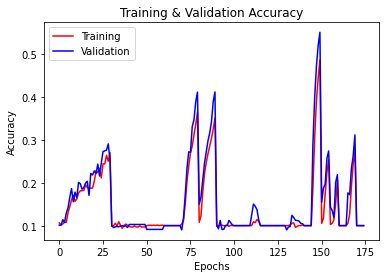

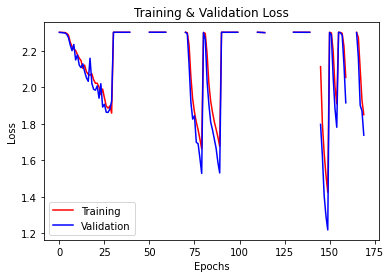

 65%|██████▌   | 13/20 [38:56<20:48, 178.42s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:20, 35.21s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1514.195438612567
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:10<01:45, 35.04s/it]

Epoch: 02 | Epoch Time: 0m 34s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1514.195438612567
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:44<01:09, 34.96s/it]

Epoch: 03 | Epoch Time: 0m 34s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1514.195438612567
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:19<00:34, 34.97s/it]

Epoch: 04 | Epoch Time: 0m 34s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1514.195438612567
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:54<00:00, 34.95s/it]

Epoch: 05 | Epoch Time: 0m 34s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 1514.195438612567
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%


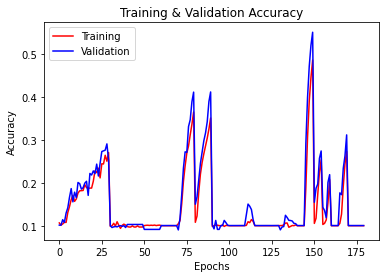

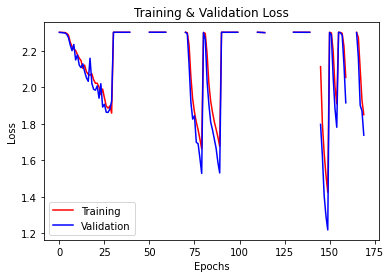

 70%|███████   | 14/20 [41:51<17:44, 177.46s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:20, 35.06s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 30.579408545195268
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:10<01:45, 35.10s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 30.579408545195268
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:45<01:10, 35.04s/it]

Epoch: 03 | Epoch Time: 0m 34s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 30.579408545195268
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:20<00:35, 35.07s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 30.579408545195268
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:55<00:00, 35.05s/it]

Epoch: 05 | Epoch Time: 0m 34s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 30.579408545195268
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%


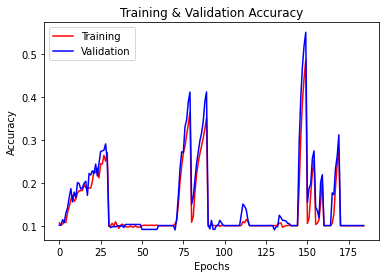

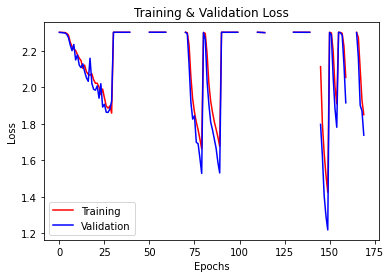

 75%|███████▌  | 15/20 [44:47<14:44, 176.95s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:21, 35.42s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1.1388089166220053e-05
	 Training Accuracy: 9.83% |  Validation Accuracy: 9.24%
Device: cuda



 40%|████      | 2/5 [01:10<01:46, 35.49s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1.1388089166220053e-05
	 Training Accuracy: 9.78% |  Validation Accuracy: 9.24%
Device: cuda



 60%|██████    | 3/5 [01:46<01:11, 35.55s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1.1388089166220053e-05
	 Training Accuracy: 9.74% |  Validation Accuracy: 9.26%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.57s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1.1388089166220053e-05
	 Training Accuracy: 9.64% |  Validation Accuracy: 9.26%
Device: cuda



100%|██████████| 5/5 [02:57<00:00, 35.53s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.303 | Learning rate: 1.1388089166220053e-05
	 Training Accuracy: 9.80% |  Validation Accuracy: 9.26%


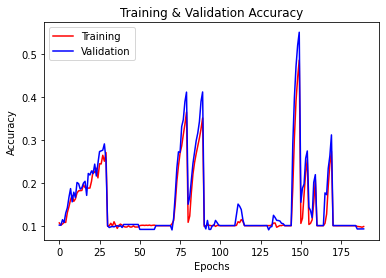

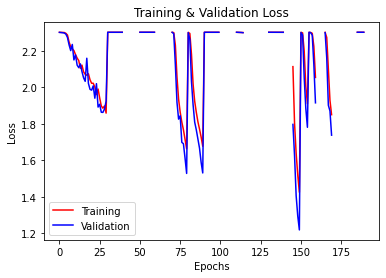

 80%|████████  | 16/20 [47:45<11:49, 177.31s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:21, 35.27s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 543.2591148530937
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:10<01:45, 35.13s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 543.2591148530937
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:45<01:10, 35.20s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 543.2591148530937
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:20<00:35, 35.16s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 543.2591148530937
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:56<00:00, 35.21s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 543.2591148530937
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%


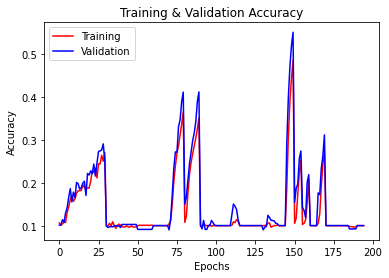

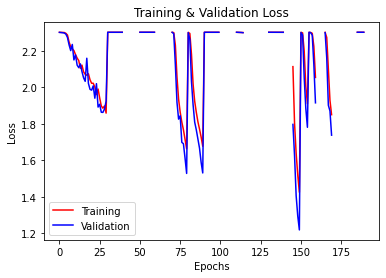

 85%|████████▌ | 17/20 [50:42<08:51, 177.09s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:37<02:28, 37.19s/it]

Epoch: 01 | Epoch Time: 0m 37s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.0008441246057121181
	 Training Accuracy: 10.17% |  Validation Accuracy: 11.45%
Device: cuda



 40%|████      | 2/5 [01:13<01:49, 36.41s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.300 | Validation Loss: 2.294 | Learning rate: 0.0008441246057121181
	 Training Accuracy: 11.06% |  Validation Accuracy: 16.24%
Device: cuda



 60%|██████    | 3/5 [01:49<01:12, 36.30s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 2.247 | Validation Loss: 2.149 | Learning rate: 0.0008441246057121181
	 Training Accuracy: 14.96% |  Validation Accuracy: 17.54%
Device: cuda



 80%|████████  | 4/5 [02:26<00:36, 36.53s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 2.104 | Validation Loss: 2.020 | Learning rate: 0.0008441246057121181
	 Training Accuracy: 18.71% |  Validation Accuracy: 18.71%
Device: cuda



100%|██████████| 5/5 [03:02<00:00, 36.40s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.987 | Validation Loss: 1.890 | Learning rate: 0.0008441246057121181
	 Training Accuracy: 21.89% |  Validation Accuracy: 22.99%


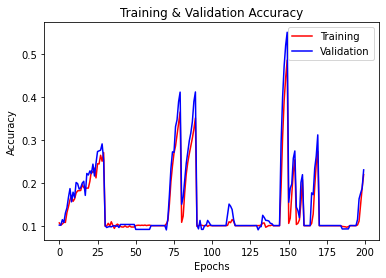

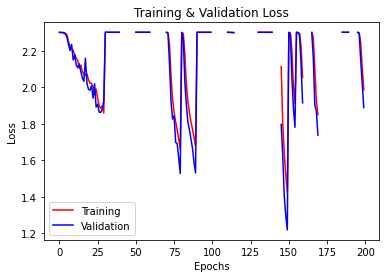

 90%|█████████ | 18/20 [53:44<05:57, 178.72s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:21, 35.34s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 13733.094941527648
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 40%|████      | 2/5 [01:10<01:45, 35.28s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 13733.094941527648
	 Training Accuracy: 10.01% |  Validation Accuracy: 10.03%
Device: cuda



 60%|██████    | 3/5 [01:45<01:10, 35.28s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 13733.094941527648
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



 80%|████████  | 4/5 [02:21<00:35, 35.26s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 13733.094941527648
	 Training Accuracy: 9.99% |  Validation Accuracy: 10.03%
Device: cuda



100%|██████████| 5/5 [02:56<00:00, 35.29s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 13733.094941527648
	 Training Accuracy: 10.00% |  Validation Accuracy: 10.03%


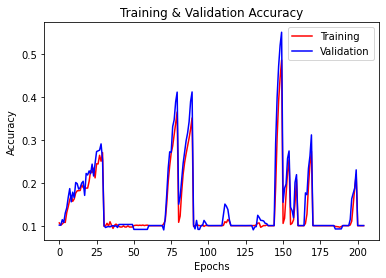

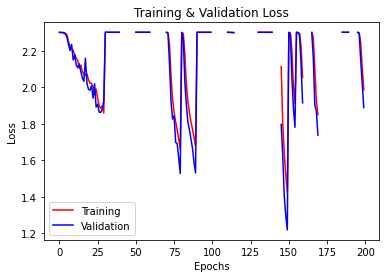

 95%|█████████▌| 19/20 [56:41<02:58, 178.20s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:22, 35.62s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.323 | Validation Loss: 2.321 | Learning rate: 0.3033366120337391
	 Training Accuracy: 10.08% |  Validation Accuracy: 11.23%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.68s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.324 | Validation Loss: 2.316 | Learning rate: 0.3033366120337391
	 Training Accuracy: 10.03% |  Validation Accuracy: 10.71%
Device: cuda



 60%|██████    | 3/5 [01:46<01:11, 35.61s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.323 | Validation Loss: 2.334 | Learning rate: 0.3033366120337391
	 Training Accuracy: 9.98% |  Validation Accuracy: 11.23%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.48s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.324 | Validation Loss: 2.342 | Learning rate: 0.3033366120337391
	 Training Accuracy: 10.06% |  Validation Accuracy: 10.11%
Device: cuda



100%|██████████| 5/5 [02:57<00:00, 35.52s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.325 | Validation Loss: 2.335 | Learning rate: 0.3033366120337391
	 Training Accuracy: 10.02% |  Validation Accuracy: 9.02%


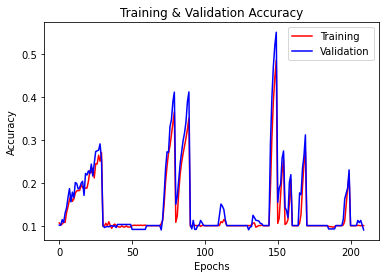

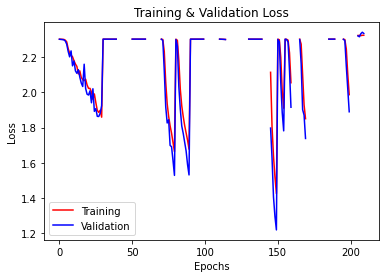

100%|██████████| 20/20 [59:40<00:00, 179.00s/it]

-----------------------------------------------------------


In [42]:
max_count = 20

for count in tqdm(range(max_count)):
  LR = 10**random.uniform(-5,5)
  reg = 10**random.uniform(-3,-6)
  tr.train_model(trainset,validset,"cuda","SGD",5,LR,reg)
  print("-----------------------------------------------------------")

### **Fine Train**

  0%|          | 0/10 [00:00<?, ?it/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:22, 35.61s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.126 | Validation Loss: 1.769 | Learning rate: 0.011332243268395086| Reg:0.00010304718875445554
	 Training Accuracy: 18.03% |  Validation Accuracy: 28.66%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.68s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 1.814 | Validation Loss: 1.560 | Learning rate: 0.011332243268395086| Reg:0.00010304718875445554
	 Training Accuracy: 30.09% |  Validation Accuracy: 39.25%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.71s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 1.645 | Validation Loss: 1.402 | Learning rate: 0.011332243268395086| Reg:0.00010304718875445554
	 Training Accuracy: 38.54% |  Validation Accuracy: 47.65%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.63s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 1.525 | Validation Loss: 1.289 | Learning rate: 0.011332243268395086| Reg:0.00010304718875445554
	 Training Accuracy: 44.03% |  Validation Accuracy: 54.20%
Device: cuda



100%|██████████| 5/5 [02:58<00:00, 35.62s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.424 | Validation Loss: 1.172 | Learning rate: 0.011332243268395086| Reg:0.00010304718875445554
	 Training Accuracy: 48.41% |  Validation Accuracy: 57.68%


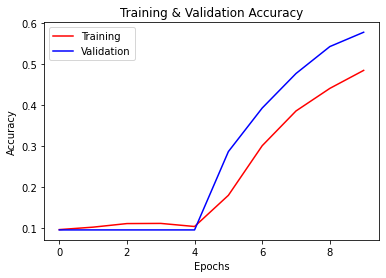

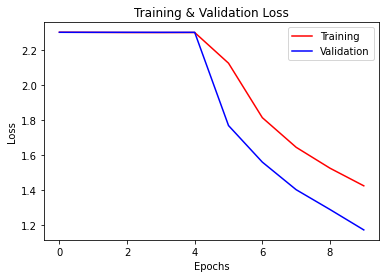

 10%|█         | 1/10 [02:58<26:47, 178.61s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.78s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.141 | Validation Loss: 1.808 | Learning rate: 0.02141598457623686| Reg:0.0005077181478357273
	 Training Accuracy: 17.07% |  Validation Accuracy: 28.26%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.91s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 1.857 | Validation Loss: 1.599 | Learning rate: 0.02141598457623686| Reg:0.0005077181478357273
	 Training Accuracy: 28.77% |  Validation Accuracy: 39.79%
Device: cuda



 60%|██████    | 3/5 [01:48<01:12, 36.07s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 1.733 | Validation Loss: 1.516 | Learning rate: 0.02141598457623686| Reg:0.0005077181478357273
	 Training Accuracy: 35.23% |  Validation Accuracy: 43.41%
Device: cuda



 80%|████████  | 4/5 [02:24<00:36, 36.07s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 1.635 | Validation Loss: 1.367 | Learning rate: 0.02141598457623686| Reg:0.0005077181478357273
	 Training Accuracy: 39.98% |  Validation Accuracy: 51.93%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.93s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.551 | Validation Loss: 1.395 | Learning rate: 0.02141598457623686| Reg:0.0005077181478357273
	 Training Accuracy: 43.63% |  Validation Accuracy: 48.81%


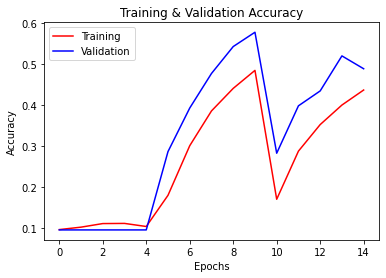

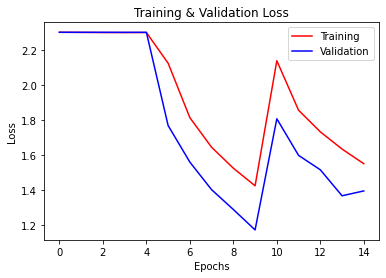

 20%|██        | 2/10 [05:58<23:55, 179.48s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:36<02:24, 36.01s/it]

Epoch: 01 | Epoch Time: 0m 36s
	 Training Loss: 2.278 | Validation Loss: 2.062 | Learning rate: 0.05057113942045359| Reg:1.8937292042193256e-05
	 Training Accuracy: 12.23% |  Validation Accuracy: 19.73%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.84s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.048 | Validation Loss: 1.827 | Learning rate: 0.05057113942045359| Reg:1.8937292042193256e-05
	 Training Accuracy: 21.28% |  Validation Accuracy: 27.19%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.70s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 1.986 | Validation Loss: 1.883 | Learning rate: 0.05057113942045359| Reg:1.8937292042193256e-05
	 Training Accuracy: 24.42% |  Validation Accuracy: 28.90%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.62s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 1.982 | Validation Loss: 1.786 | Learning rate: 0.05057113942045359| Reg:1.8937292042193256e-05
	 Training Accuracy: 24.35% |  Validation Accuracy: 27.07%
Device: cuda



100%|██████████| 5/5 [02:58<00:00, 35.64s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.985 | Validation Loss: 1.888 | Learning rate: 0.05057113942045359| Reg:1.8937292042193256e-05
	 Training Accuracy: 24.40% |  Validation Accuracy: 26.77%


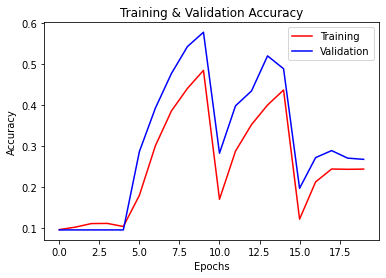

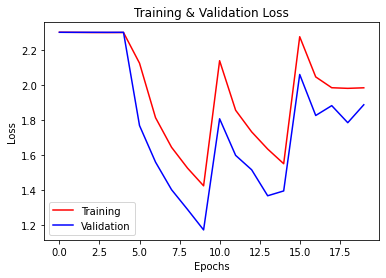

 30%|███       | 3/10 [08:57<20:53, 179.11s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.83s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.0004558461970178838| Reg:3.106318178736199e-05
	 Training Accuracy: 10.42% |  Validation Accuracy: 10.37%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.89s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.301 | Learning rate: 0.0004558461970178838| Reg:3.106318178736199e-05
	 Training Accuracy: 10.96% |  Validation Accuracy: 12.00%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.87s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.301 | Validation Loss: 2.299 | Learning rate: 0.0004558461970178838| Reg:3.106318178736199e-05
	 Training Accuracy: 11.39% |  Validation Accuracy: 21.30%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.83s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.298 | Validation Loss: 2.290 | Learning rate: 0.0004558461970178838| Reg:3.106318178736199e-05
	 Training Accuracy: 11.98% |  Validation Accuracy: 20.60%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.89s/it]

Epoch: 05 | Epoch Time: 0m 36s
	 Training Loss: 2.268 | Validation Loss: 2.179 | Learning rate: 0.0004558461970178838| Reg:3.106318178736199e-05
	 Training Accuracy: 13.96% |  Validation Accuracy: 16.38%


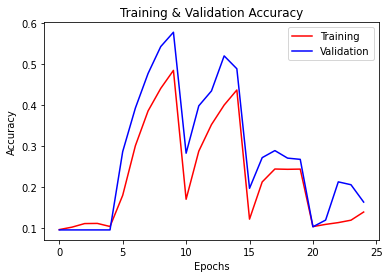

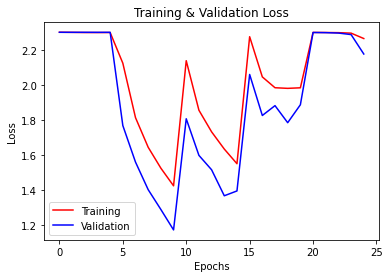

 40%|████      | 4/10 [11:57<17:56, 179.46s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:22, 35.70s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.256 | Validation Loss: 2.121 | Learning rate: 0.06679258340530575| Reg:0.000572787626704512
	 Training Accuracy: 12.69% |  Validation Accuracy: 14.65%
Device: cuda



 40%|████      | 2/5 [01:11<01:46, 35.65s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.120 | Validation Loss: 2.061 | Learning rate: 0.06679258340530575| Reg:0.000572787626704512
	 Training Accuracy: 16.91% |  Validation Accuracy: 17.75%
Device: cuda



 60%|██████    | 3/5 [01:46<01:11, 35.62s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.088 | Validation Loss: 1.983 | Learning rate: 0.06679258340530575| Reg:0.000572787626704512
	 Training Accuracy: 18.78% |  Validation Accuracy: 22.53%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.59s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 2.084 | Validation Loss: 1.971 | Learning rate: 0.06679258340530575| Reg:0.000572787626704512
	 Training Accuracy: 18.93% |  Validation Accuracy: 22.47%
Device: cuda



100%|██████████| 5/5 [02:58<00:00, 35.64s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.075 | Validation Loss: 1.917 | Learning rate: 0.06679258340530575| Reg:0.000572787626704512
	 Training Accuracy: 19.47% |  Validation Accuracy: 23.59%


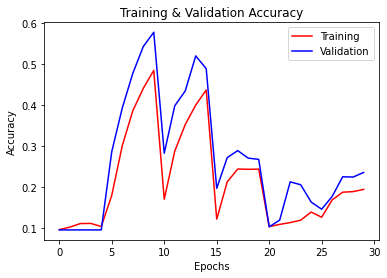

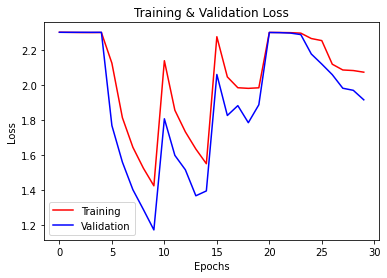

 50%|█████     | 5/10 [14:56<14:55, 179.18s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.96s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.303 | Validation Loss: 2.302 | Learning rate: 0.00015954430258650104| Reg:6.445742199616918e-05
	 Training Accuracy: 10.04% |  Validation Accuracy: 10.89%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.99s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.00015954430258650104| Reg:6.445742199616918e-05
	 Training Accuracy: 10.34% |  Validation Accuracy: 11.35%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.85s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.00015954430258650104| Reg:6.445742199616918e-05
	 Training Accuracy: 10.25% |  Validation Accuracy: 13.44%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.93s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.00015954430258650104| Reg:6.445742199616918e-05
	 Training Accuracy: 11.04% |  Validation Accuracy: 14.93%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.91s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.00015954430258650104| Reg:6.445742199616918e-05
	 Training Accuracy: 10.96% |  Validation Accuracy: 14.39%


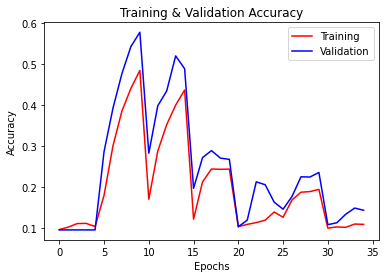

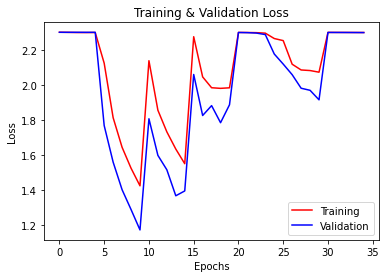

 60%|██████    | 6/10 [17:56<11:57, 179.47s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.87s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.302 | Learning rate: 0.0007526386612597662| Reg:0.00024003949650870746
	 Training Accuracy: 10.06% |  Validation Accuracy: 13.73%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.85s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.301 | Validation Loss: 2.298 | Learning rate: 0.0007526386612597662| Reg:0.00024003949650870746
	 Training Accuracy: 10.91% |  Validation Accuracy: 18.85%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.73s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.276 | Validation Loss: 2.169 | Learning rate: 0.0007526386612597662| Reg:0.00024003949650870746
	 Training Accuracy: 13.09% |  Validation Accuracy: 16.70%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.88s/it]

Epoch: 04 | Epoch Time: 0m 36s
	 Training Loss: 2.153 | Validation Loss: 2.041 | Learning rate: 0.0007526386612597662| Reg:0.00024003949650870746
	 Training Accuracy: 17.74% |  Validation Accuracy: 19.59%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.85s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 2.054 | Validation Loss: 1.923 | Learning rate: 0.0007526386612597662| Reg:0.00024003949650870746
	 Training Accuracy: 19.21% |  Validation Accuracy: 22.21%


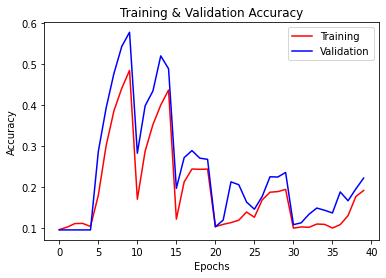

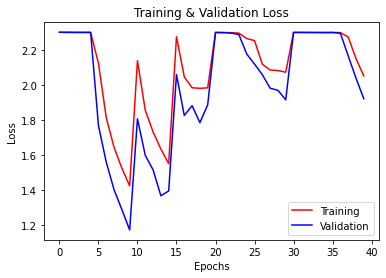

 70%|███████   | 7/10 [20:55<08:58, 179.55s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.77s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.113 | Validation Loss: 1.798 | Learning rate: 0.030527663328569835| Reg:4.992740092714583e-05
	 Training Accuracy: 17.88% |  Validation Accuracy: 28.40%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 35.72s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 1.867 | Validation Loss: 1.656 | Learning rate: 0.030527663328569835| Reg:4.992740092714583e-05
	 Training Accuracy: 28.63% |  Validation Accuracy: 37.76%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.69s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 1.761 | Validation Loss: 1.503 | Learning rate: 0.030527663328569835| Reg:4.992740092714583e-05
	 Training Accuracy: 34.30% |  Validation Accuracy: 43.33%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.71s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 1.697 | Validation Loss: 1.427 | Learning rate: 0.030527663328569835| Reg:4.992740092714583e-05
	 Training Accuracy: 37.28% |  Validation Accuracy: 47.29%
Device: cuda



100%|██████████| 5/5 [02:58<00:00, 35.66s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.656 | Validation Loss: 1.464 | Learning rate: 0.030527663328569835| Reg:4.992740092714583e-05
	 Training Accuracy: 39.74% |  Validation Accuracy: 48.29%


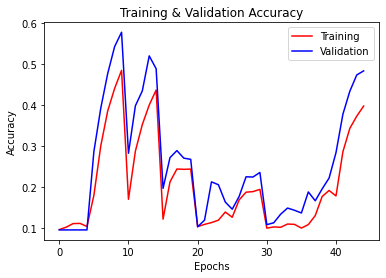

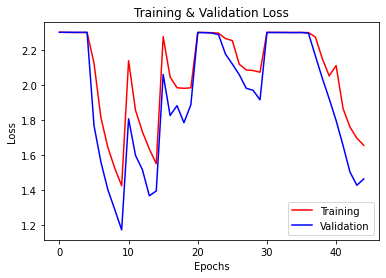

 80%|████████  | 8/10 [23:54<05:58, 179.30s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:22, 35.70s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.279 | Validation Loss: 2.142 | Learning rate: 0.09885448109437764| Reg:7.304208193953323e-05
	 Training Accuracy: 12.35% |  Validation Accuracy: 15.25%
Device: cuda



 40%|████      | 2/5 [01:11<01:46, 35.61s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 2.236 | Validation Loss: 2.187 | Learning rate: 0.09885448109437764| Reg:7.304208193953323e-05
	 Training Accuracy: 14.00% |  Validation Accuracy: 17.40%
Device: cuda



 60%|██████    | 3/5 [01:46<01:11, 35.58s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 2.250 | Validation Loss: 2.130 | Learning rate: 0.09885448109437764| Reg:7.304208193953323e-05
	 Training Accuracy: 13.52% |  Validation Accuracy: 17.38%
Device: cuda



 80%|████████  | 4/5 [02:22<00:35, 35.48s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.09885448109437764| Reg:7.304208193953323e-05
	 Training Accuracy: 11.31% |  Validation Accuracy: 10.27%
Device: cuda



100%|██████████| 5/5 [02:57<00:00, 35.49s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: nan | Validation Loss: nan | Learning rate: 0.09885448109437764| Reg:7.304208193953323e-05
	 Training Accuracy: 9.97% |  Validation Accuracy: 10.27%


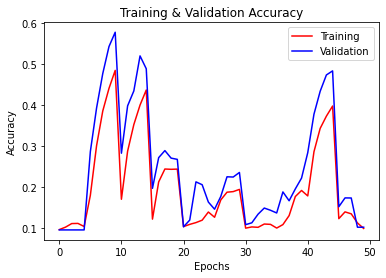

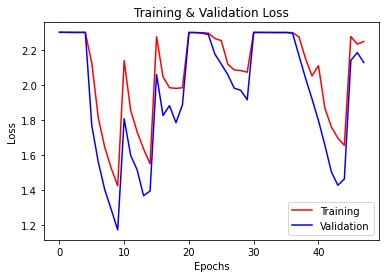

 90%|█████████ | 9/10 [26:52<02:58, 178.88s/it]

-----------------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=


  0%|          | 0/5 [00:00<?, ?it/s]

Device: cuda



 20%|██        | 1/5 [00:35<02:23, 35.83s/it]

Epoch: 01 | Epoch Time: 0m 35s
	 Training Loss: 2.302 | Validation Loss: 2.296 | Learning rate: 0.002162533869225007| Reg:0.0009439422942567006
	 Training Accuracy: 10.68% |  Validation Accuracy: 15.31%
Device: cuda



 40%|████      | 2/5 [01:11<01:47, 36.00s/it]

Epoch: 02 | Epoch Time: 0m 36s
	 Training Loss: 2.171 | Validation Loss: 1.930 | Learning rate: 0.002162533869225007| Reg:0.0009439422942567006
	 Training Accuracy: 17.67% |  Validation Accuracy: 24.48%
Device: cuda



 60%|██████    | 3/5 [01:47<01:11, 35.91s/it]

Epoch: 03 | Epoch Time: 0m 35s
	 Training Loss: 1.942 | Validation Loss: 1.786 | Learning rate: 0.002162533869225007| Reg:0.0009439422942567006
	 Training Accuracy: 24.11% |  Validation Accuracy: 27.55%
Device: cuda



 80%|████████  | 4/5 [02:23<00:35, 35.86s/it]

Epoch: 04 | Epoch Time: 0m 35s
	 Training Loss: 1.840 | Validation Loss: 1.706 | Learning rate: 0.002162533869225007| Reg:0.0009439422942567006
	 Training Accuracy: 27.75% |  Validation Accuracy: 32.23%
Device: cuda



100%|██████████| 5/5 [02:59<00:00, 35.84s/it]

Epoch: 05 | Epoch Time: 0m 35s
	 Training Loss: 1.773 | Validation Loss: 1.746 | Learning rate: 0.002162533869225007| Reg:0.0009439422942567006
	 Training Accuracy: 30.81% |  Validation Accuracy: 32.94%


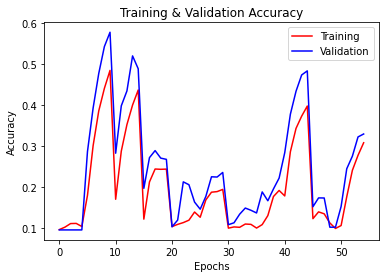

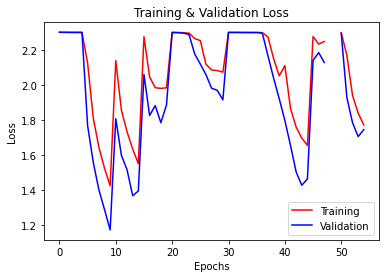

100%|██████████| 10/10 [29:52<00:00, 179.22s/it]

-----------------------------------------------------------


In [47]:
max_count = 10

for count in tqdm(range(max_count)):
  LR = 10**random.uniform(-4,-0)
  reg = 10**random.uniform(-3,-5)
  tr.train_model(trainset,validset,"cuda","SGD",5,LR,reg)
  print("-----------------------------------------------------------")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

  0%|          | 0/20 [00:00<?, ?it/s]

Device: cuda


  5%|▌         | 1/20 [00:37<11:50, 37.39s/it]

Epoch: 01 | Epoch Time: 0m 37s
	 Training Loss: 2.160 | Validation Loss: 1.799 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 16.26% |  Validation Accuracy: 29.36%
Device: cuda


 10%|█         | 2/20 [01:13<10:56, 36.48s/it]

Epoch: 02 | Epoch Time: 0m 35s
	 Training Loss: 1.835 | Validation Loss: 1.649 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 29.07% |  Validation Accuracy: 37.08%
Device: cuda


 15%|█▌        | 3/20 [01:49<10:20, 36.47s/it]

Epoch: 03 | Epoch Time: 0m 36s
	 Training Loss: 1.667 | Validation Loss: 1.417 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 37.54% |  Validation Accuracy: 46.72%
Device: cuda


 20%|██        | 4/20 [02:30<10:08, 38.02s/it]

Epoch: 04 | Epoch Time: 0m 40s
	 Training Loss: 1.532 | Validation Loss: 1.257 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 44.01% |  Validation Accuracy: 53.76%
Device: cuda


 25%|██▌       | 5/20 [03:06<09:22, 37.50s/it]

Epoch: 05 | Epoch Time: 0m 36s
	 Training Loss: 1.430 | Validation Loss: 1.257 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 48.45% |  Validation Accuracy: 53.76%
Device: cuda


 30%|███       | 6/20 [03:42<08:38, 37.05s/it]

Epoch: 06 | Epoch Time: 0m 36s
	 Training Loss: 1.355 | Validation Loss: 1.134 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 51.58% |  Validation Accuracy: 60.03%
Device: cuda


 35%|███▌      | 7/20 [04:19<07:57, 36.77s/it]

Epoch: 07 | Epoch Time: 0m 36s
	 Training Loss: 1.292 | Validation Loss: 1.128 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 54.02% |  Validation Accuracy: 59.77%
Device: cuda


 40%|████      | 8/20 [04:55<07:18, 36.53s/it]

Epoch: 08 | Epoch Time: 0m 36s
	 Training Loss: 1.243 | Validation Loss: 1.016 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 56.28% |  Validation Accuracy: 64.37%
Device: cuda


 45%|████▌     | 9/20 [05:30<06:39, 36.33s/it]

Epoch: 09 | Epoch Time: 0m 35s
	 Training Loss: 1.189 | Validation Loss: 0.985 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 58.12% |  Validation Accuracy: 65.66%
Device: cuda


 50%|█████     | 10/20 [06:06<06:01, 36.16s/it]

Epoch: 10 | Epoch Time: 0m 35s
	 Training Loss: 1.163 | Validation Loss: 0.971 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 59.16% |  Validation Accuracy: 65.66%
Device: cuda


 55%|█████▌    | 11/20 [06:42<05:23, 35.99s/it]

Epoch: 11 | Epoch Time: 0m 35s
	 Training Loss: 1.115 | Validation Loss: 1.001 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 60.88% |  Validation Accuracy: 64.81%
Device: cuda


 60%|██████    | 12/20 [07:18<04:47, 35.98s/it]

Epoch: 12 | Epoch Time: 0m 35s
	 Training Loss: 1.094 | Validation Loss: 0.952 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 61.76% |  Validation Accuracy: 66.50%
Device: cuda


 65%|██████▌   | 13/20 [07:54<04:11, 35.94s/it]

Epoch: 13 | Epoch Time: 0m 35s
	 Training Loss: 1.069 | Validation Loss: 0.928 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 62.73% |  Validation Accuracy: 66.72%
Device: cuda


 70%|███████   | 14/20 [08:29<03:35, 35.88s/it]

Epoch: 14 | Epoch Time: 0m 35s
	 Training Loss: 1.051 | Validation Loss: 0.883 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 63.39% |  Validation Accuracy: 68.83%
Device: cuda


 75%|███████▌  | 15/20 [09:05<02:58, 35.79s/it]

Epoch: 15 | Epoch Time: 0m 35s
	 Training Loss: 1.031 | Validation Loss: 0.908 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 64.49% |  Validation Accuracy: 68.75%
Device: cuda


 80%|████████  | 16/20 [09:40<02:22, 35.66s/it]

Epoch: 16 | Epoch Time: 0m 35s
	 Training Loss: 1.006 | Validation Loss: 0.897 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 65.04% |  Validation Accuracy: 69.25%
Device: cuda


 85%|████████▌ | 17/20 [10:16<01:46, 35.59s/it]

Epoch: 17 | Epoch Time: 0m 35s
	 Training Loss: 0.990 | Validation Loss: 0.898 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 65.53% |  Validation Accuracy: 69.13%
Device: cuda


 90%|█████████ | 18/20 [10:51<01:11, 35.58s/it]

Epoch: 18 | Epoch Time: 0m 35s
	 Training Loss: 0.977 | Validation Loss: 0.853 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 66.21% |  Validation Accuracy: 70.52%
Device: cuda


 95%|█████████▌| 19/20 [11:27<00:35, 35.62s/it]

Epoch: 19 | Epoch Time: 0m 35s
	 Training Loss: 0.958 | Validation Loss: 0.848 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 66.75% |  Validation Accuracy: 71.20%
Device: cuda


100%|██████████| 20/20 [12:03<00:00, 36.16s/it]

Epoch: 20 | Epoch Time: 0m 35s
	 Training Loss: 0.946 | Validation Loss: 0.846 | Learning rate: 0.01| Reg:0.00011
	 Training Accuracy: 67.25% |  Validation Accuracy: 70.64%


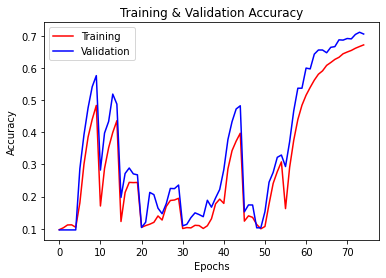

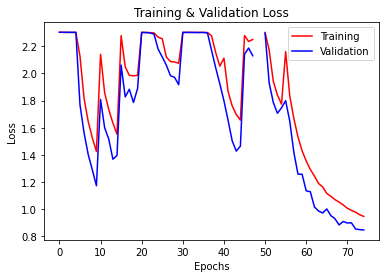

In [51]:
LR = 0.01
reg = 0.00011
tr.train_model(trainset,validset,device,'SGD',20,LR,reg)

**Test Loss and accuracy:**

In [52]:
test_loss, test_acc = tr.evaluate(tr.model, testset, criterion, device)
print(f'Test Accuracy: {test_acc} | Test Loss: {test_loss}')

Test Accuracy: 0.7069688498402555 | Test Loss: 0.859009473563764
